# McFly based Train Signal Classification

This notebook uses the open-source time series classification library "McFly":

- [mcfly](https://github.com/NLeSC/mcfly)
- [mcfly tutorial](https://github.com/NLeSC/mcfly-tutorial)

This notebook is inspired by the following tutorials:

- [tutorial.ipynb](https://github.com/NLeSC/mcfly-tutorial/blob/main/notebooks/tutorial/tutorial.ipynb)
- [tutorial_quick.ipynb](https://github.com/NLeSC/mcfly-tutorial/blob/main/notebooks/tutorial/tutorial_quick.ipynb)

In [1]:
%pip install -qqq "tensorflow[and-cuda]" "git+https://github.com/NLeSC/mcfly.git@v4.1.2"

Note: you may need to restart the kernel to use updated packages.


In [2]:
%env KERAS_BACKEND=tensorflow
%load_ext autoreload
%autoreload 2
%matplotlib inline

env: KERAS_BACKEND=tensorflow


In [3]:
import os
from textwrap import indent

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import mcfly
import numpy as np
import pandas as pd
from tabulate import tabulate

2025-07-11 11:56:11.202813: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-11 11:56:11.217697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752227771.234447  604826 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752227771.239601  604826 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752227771.252791  604826 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [4]:
from _defaults import (
    CACHING_ENABLED,
    SEED,
    datasets_labels,
    get_data_hash_key,
    init_notebook,
    load_ballance_datasets,
    print_db_length_table,
)

In [5]:
init_notebook()
keras.utils.set_random_seed(SEED)

Load data.

In [6]:
data_limit = 100
_, (dataset, metadata, targets) = load_ballance_datasets(max_length=data_limit)

Load previous cached dataset from './cache/datasets-18f8d4b7.pkl' file.


In [7]:
print_db_length_table(targets)

Dataset         Length
------------  --------
Fernverkehr        100
Güterverkehr       100
Regioverkehr       100


Prepare caching.

In [8]:
data_hash = get_data_hash_key()

Label one hot encoding and data reshaping (optimized for McFly algorithm).

In [9]:
data_all = np.expand_dims(dataset, axis=-1)
label_all = pd.get_dummies(pd.DataFrame(np.array(datasets_labels)[targets]), dtype=int).to_numpy()

Splitting dataset:

- 60% train set
- 30% validation set
- 10% train set

In [10]:
size_10_percent = int(len(data_all) * 0.1)

# train set: 60%
train_data = data_all[0 : -size_10_percent * 4]
train_label = label_all[0 : -size_10_percent * 4]
# validation set: 30%
val_data = data_all[-size_10_percent * 4 : -size_10_percent]
val_label = label_all[-size_10_percent * 4 : -size_10_percent]
# test set: 10%
test_data = data_all[-size_10_percent:]
test_label = label_all[-size_10_percent:]

print(np.shape(train_data))
print(np.shape(val_data))
print(np.shape(test_data))

(180, 1000, 1)
(90, 1000, 1)
(30, 1000, 1)


In [11]:
del data_all
del label_all
del size_10_percent

Mcfly provides 'CNN', 'DeepConvLSTM', 'ResNet', 'InceptionTime'. In a preliminary study, it turned out that 'InceptionTime' works the best in our case. We will specify 'InceptionTime' instead of try all the models.

In [12]:
num_classes = len(datasets_labels)  # 3
metric = "categorical_accuracy"
models = mcfly.modelgen.generate_models(
    train_data.shape,
    model_types=["InceptionTime"],
    number_of_output_dimensions=num_classes,
    number_of_models=5,
    metrics=[metric],
)

I0000 00:00:1752227776.094586  604826 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46866 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:65:00.0, compute capability: 8.6
I0000 00:00:1752227776.095263  604826 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 45679 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:b3:00.0, compute capability: 8.6


## Inspect the models

In [13]:
from IPython.core.display import HTML
from IPython.core.display_functions import display
from IPython.utils.io import capture_output

In [14]:
def collapsible_summary(model, title: str = "Model Summary") -> None:
    with capture_output() as captured:
        model.summary()
    summary = "".join([out._repr_html_() for out in captured.outputs])
    display(HTML(f"<details><summary>{title}</summary>{summary}</details>"))

In [15]:
for idx, item in enumerate(models):
    model, params, model_types = item
    collapsible_summary(model, f"Model {idx} Summary")
    print("Model type:", model_types)
    print("Hyperparameters:")
    print(indent(tabulate(params.items(), tablefmt="plain"), "  "))
    print("-" * 80)

Model type: InceptionTime
Hyperparameters:
  learning_rate         0.0075228
  regularization_rate   0.000140558
  network_depth         5
  filters_number       92
  max_kernel_size      30
--------------------------------------------------------------------------------


Model type: InceptionTime
Hyperparameters:
  learning_rate         0.0340364
  regularization_rate   0.0340421
  network_depth         5
  filters_number       55
  max_kernel_size      12
--------------------------------------------------------------------------------


Model type: InceptionTime
Hyperparameters:
  learning_rate         0.0867454
  regularization_rate   0.000123104
  network_depth         6
  filters_number       61
  max_kernel_size      47
--------------------------------------------------------------------------------


Model type: InceptionTime
Hyperparameters:
  learning_rate         0.0994635
  regularization_rate   0.000105527
  network_depth         3
  filters_number       89
  max_kernel_size      31
--------------------------------------------------------------------------------


Model type: InceptionTime
Hyperparameters:
  learning_rate         0.095236
  regularization_rate   0.0852732
  network_depth         5
  filters_number       90
  max_kernel_size      51
--------------------------------------------------------------------------------


## Compare models

In [16]:
# Define directory where the results, e.g. json file, will be stored
resultpath = "./cache/models"
os.makedirs(resultpath, exist_ok=True)

In [17]:
outputfile = os.path.join(resultpath, "modelcomparison.json")
histories, val_accuracies, val_losses = mcfly.find_architecture.train_models_on_samples(
    train_data,
    train_label,
    val_data,
    val_label,
    models,
    nr_epochs=5,
    subset_size=100,
    verbose=True,
    outputfile=outputfile,
)
print()
print("Details of the training process were stored in", outputfile)

Generated models will be trained on subset of the data (subset size: 100).
Training model 0 InceptionTime
Epoch 1/5


I0000 00:00:1752227782.794351  605281 service.cc:152] XLA service 0x72ad94001ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752227782.794378  605281 service.cc:160]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
I0000 00:00:1752227782.794382  605281 service.cc:160]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2025-07-11 11:56:22.944953: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752227783.604611  605281 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-11 11:56:25.942722: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3439', 88 bytes spill stores, 88 bytes spill loads

2025-07-11 11:56:25.968397: I external/local_xla/xla/stream_executor/cuda/su

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_accuracy: 0.3458 - loss: 1.6234

I0000 00:00:1752227790.611647  605281 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-07-11 11:56:33.414198: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_345', 88 bytes spill stores, 88 bytes spill loads

2025-07-11 11:56:33.480940: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_345', 88 bytes spill stores, 88 bytes spill loads



5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - categorical_accuracy: 0.3549 - loss: 1.6268 - val_categorical_accuracy: 0.3444 - val_loss: 672.2557
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - categorical_accuracy: 0.4690 - loss: 1.1320 - val_categorical_accuracy: 0.3444 - val_loss: 213.1189
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.6128 - loss: 0.8400 - val_categorical_accuracy: 0.3444 - val_loss: 55.9235
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_accuracy: 0.6450 - loss: 0.8091 - val_categorical_accuracy: 0.3444 - val_loss: 60.5708
Epoch 4: early stopping
Training model 1 InceptionTime
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 938ms/step - categorical_accuracy: 0.4418 - loss: 1.1505 - val_categorical_accuracy: 0.3444 - val_loss: 13042.2197
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.5326 - loss: 0.9701 - val_categorical_accuracy: 0.3444 - val_loss: 4668.9863
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - cat

2025-07-11 11:57:13.825857: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2231', 84 bytes spill stores, 84 bytes spill loads

2025-07-11 11:57:13.841033: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2231', 308 bytes spill stores, 308 bytes spill loads

2025-07-11 11:57:13.934396: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2231', 84 bytes spill stores, 84 bytes spill loads



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.3283 - loss: 7.7130

2025-07-11 11:57:19.828626: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_241', 84 bytes spill stores, 84 bytes spill loads

2025-07-11 11:57:19.889020: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_241', 84 bytes spill stores, 84 bytes spill loads



5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 948ms/step - categorical_accuracy: 0.3319 - loss: 7.7679 - val_categorical_accuracy: 0.3444 - val_loss: 1722.8490
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.2763 - loss: 3.2809 - val_categorical_accuracy: 0.3444 - val_loss: 389.1785
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.4822 - loss: 1.1020 - val_categorical_accuracy: 0.2333 - val_loss: 73.1654
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.4376 - loss: 1.0799 - val_categorical_accuracy: 0.2333 - val_loss: 47.4035
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.4500 - loss: 1.0511 - val_categorical_accuracy: 0.3444 - val_loss: 24.2958
Training model 4 InceptionTime
Epoch 1/5


2025-07-11 11:57:29.443432: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3439', 84 bytes spill stores, 84 bytes spill loads

2025-07-11 11:57:29.821174: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3439', 84 bytes spill stores, 84 bytes spill loads

2025-07-11 11:57:29.927050: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3439', 308 bytes spill stores, 308 bytes spill loads



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_accuracy: 0.3703 - loss: 5.5731

2025-07-11 11:57:36.975875: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_345', 84 bytes spill stores, 84 bytes spill loads

2025-07-11 11:57:36.990520: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_345', 84 bytes spill stores, 84 bytes spill loads



5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 977ms/step - categorical_accuracy: 0.3686 - loss: 5.5352 - val_categorical_accuracy: 0.3444 - val_loss: 157151.5156
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - categorical_accuracy: 0.4328 - loss: 1.6616 - val_categorical_accuracy: 0.4222 - val_loss: 18178.5117
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - categorical_accuracy: 0.3071 - loss: 1.2363 - val_categorical_accuracy: 0.3444 - val_loss: 2057.3530
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.4386 - loss: 1.0901 - val_categorical_accuracy: 0.2333 - val_loss: 2370.3445
Epoch 4: early stopping

Details of the training process were stored in ./cache/models/modelcomparison.json


## Inspect model performance

In [18]:
metric = "categorical_accuracy"
modelcomparisons = pd.DataFrame(
    {
        "model": [str(params) for model, params, model_types in models],
        f"train_{metric}": [history.history[metric][-1] for history in histories],
        "train_loss": [history.history["loss"][-1] for history in histories],
        f"val_{metric}": [history.history[f"val_{metric}"][-1] for history in histories],
        "val_loss": [history.history["val_loss"][-1] for history in histories],
    }
)
modelcomparisons.to_csv(os.path.join(resultpath, "mcfly-modelcomparisons.csv"))

modelcomparisons

,model,train_categorical_accuracy,train_loss,val_categorical_accuracy,val_loss
0,"{'learning_rate': 0.007522802209776488, 'regul...",0.66,0.797029,0.344444,60.570801
1,"{'learning_rate': 0.03403643603339151, 'regula...",0.66,0.668257,0.344444,1874.416016
2,"{'learning_rate': 0.08674541260988823, 'regula...",0.50,0.994411,0.344444,21638.580078
3,"{'learning_rate': 0.09946349198773344, 'regula...",0.45,1.039031,0.344444,24.295834
4,"{'learning_rate': 0.09523598640287477, 'regula...",0.42,1.100337,0.233333,2370.344482


## Choose the best model

In [19]:
best_model_index = np.argmax(val_accuracies)
best_model, best_params, best_model_types = models[best_model_index]
print("Model type and parameters of the best model:", best_model_types)
print(tabulate(best_params.items()))

Model type and parameters of the best model: InceptionTime
-------------------  ------------
learning_rate         0.0075228
regularization_rate   0.000140558
network_depth         5
filters_number       92
max_kernel_size      30
-------------------  ------------


## Train the best model on the full dataset

In [20]:
cache_file = os.path.join(resultpath, "mcfly_bestmodel.keras")

if CACHING_ENABLED and os.path.exists(cache_file):
    print(f"Load previous cached McFly model from '{cache_file}' file.")
    model = keras.models.load_model(cache_file)
else:
    # We make a copy of the model, to start training from fresh
    nr_epochs = 50
    datasize = train_data.shape[0]  # change in `X_train.shape[0]` if training complete data set

    checkpoint = ModelCheckpoint(cache_file, monitor="val_loss", save_best_only=True)
    early_stop = EarlyStopping(monitor="val_loss", patience=25)

    history = best_model.fit(
        train_data[:datasize, :, :],
        train_label[:datasize, :],
        epochs=nr_epochs,
        validation_data=(val_data, val_label),
        callbacks=[checkpoint, early_stop],
    )

    best_model.save(cache_file)
    model = best_model

Epoch 1/50


2025-07-11 11:57:43.917423: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3438', 208 bytes spill stores, 208 bytes spill loads

2025-07-11 11:57:44.398944: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3438', 52 bytes spill stores, 52 bytes spill loads

2025-07-11 11:57:44.469233: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3438', 52 bytes spill stores, 52 bytes spill loads



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - categorical_accuracy: 0.6593 - loss: 0.8973

2025-07-11 11:57:55.029121: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344', 88 bytes spill stores, 88 bytes spill loads

2025-07-11 11:57:55.280990: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344', 308 bytes spill stores, 308 bytes spill loads

2025-07-11 11:57:55.310098: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344', 88 bytes spill stores, 88 bytes spill loads



6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - categorical_accuracy: 0.6564 - loss: 0.8947 - val_categorical_accuracy: 0.3444 - val_loss: 90.7720
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - categorical_accuracy: 0.6187 - loss: 0.8412 - val_categorical_accuracy: 0.3444 - val_loss: 88.8273
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - categorical_accuracy: 0.6660 - loss: 0.7906 - val_categorical_accuracy: 0.3444 - val_loss: 69.9529
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - categorical_accuracy: 0.7121 - loss: 0.7018 - val_categorical_accuracy: 0.3444 - val_loss: 55.5840
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - categorical_accuracy: 0.7479 - loss: 0.6421 - val_categorical_accuracy: 0.3444 - val_loss: 39.3151
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - categorical_accuracy: 0.7812 - loss: 0.5937 - val_categorical_accuracy: 0.3444 - val_loss: 27.9713
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - categorical_accuracy: 0.8128 - loss: 0.5028 - val_categorical

## Investigate model predictions

In [21]:
# Inspect model predictions on validation data
datasize = val_data.shape[0]
probs = model.predict(val_data[:datasize, :, :], batch_size=1)

90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [22]:
np.save(os.path.join(resultpath, "probs.npy"), probs)
np.save(os.path.join(resultpath, "val_label.npy"), val_label)
probs = np.load(os.path.join(resultpath, "probs.npy"))
val_label = np.load(os.path.join(resultpath, "val_label.npy"))

In [23]:
print(np.shape(probs))
print(np.shape(val_label))

(90, 3)
(90, 3)


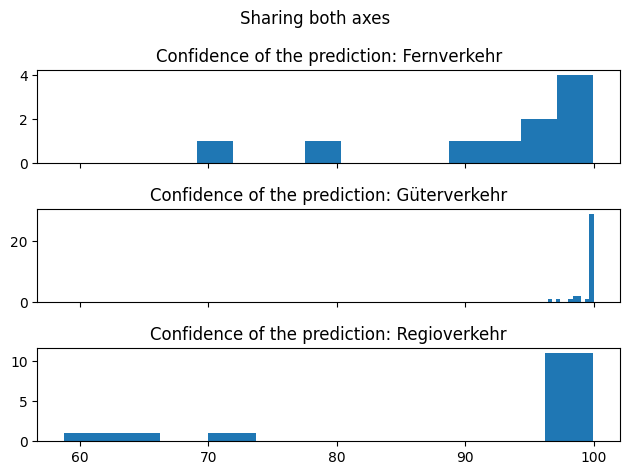

,Fernverkehr,Güterverkehr,Regioverkehr
Fernverkehr,10,14,7
Güterverkehr,0,37,1
Regioverkehr,1,6,14


In [24]:
# columns are predicted, rows are truth
predicted = probs.argmax(axis=1)
y_index = val_label.argmax(axis=1)

true_positive = predicted == y_index
non_true_positive = predicted != y_index

newset = np.concatenate((probs, true_positive[:, np.newaxis]), axis=1)
newset = np.concatenate((newset, non_true_positive[:, np.newaxis]), axis=1)
newset = np.concatenate((newset, predicted[:, np.newaxis]), axis=1)

newset = np.concatenate((newset, y_index[:, np.newaxis]), axis=1)
newset = pd.DataFrame(data=newset)

columns = datasets_labels
columns_dum = ["Prob_Fern", "Prob_Güter", "Prob_Regio"]
newset.columns = ["Prob_Fern", "Prob_Güter", "Prob_Regio", "True_Positive", "Non_True_Positive", "Prediction", "Label"]
newset["Non_True_Positive"] = newset["Non_True_Positive"].astype(bool)
newset["True_Positive"] = newset["True_Positive"].astype(bool)
newset["Prediction"] = newset["Prediction"].astype(int)

fig, axs = plt.subplots(len(columns), sharex=True)
fig.suptitle("Sharing both axes")

# 0:TGV, 1:Güter, 2:Fernverkehr
for i, col in enumerate(columns):
    bins = np.linspace(0, 100, 11, endpoint=True)
    axs[i].set_title("Confidence of the prediction: " + col)
    test = newset.loc[(newset["Prediction"] == i) & (newset["True_Positive"] == True), columns_dum[i]]  # noqa: E712
    axs[i].hist(test * 100, bins=len(bins))
plt.tight_layout()
plt.show()

confusion_matrix = pd.crosstab(pd.Series(y_index), pd.Series(predicted))
labels = datasets_labels
confusion_matrix.index = [labels[i] for i in confusion_matrix.index]
confusion_matrix.columns = [labels[i] for i in confusion_matrix.columns]
confusion_matrix.reindex(columns=y_index.tolist(), fill_value=0)
confusion_matrix

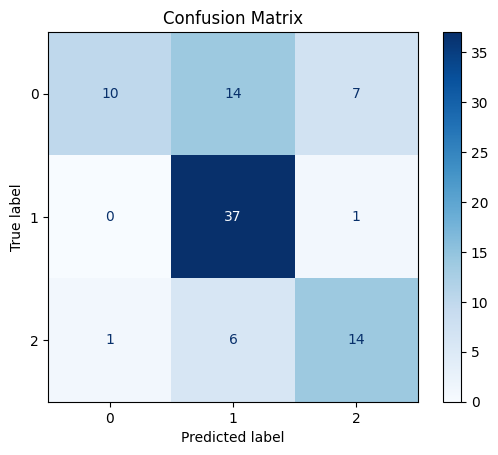

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay


disp = ConfusionMatrixDisplay.from_predictions(pd.Series(y_index), pd.Series(predicted), cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [26]:
tp_index = []
for i in range(len(columns)):
    test = newset.loc[(newset["Prediction"] == i) & (newset["True_Positive"] == True), columns_dum[i]]  # noqa: E712
    tp_index.append(test.index.tolist())

fp_index = []
for i in range(len(columns)):
    test = newset.loc[(newset["Prediction"] == i) & (newset["Non_True_Positive"] == True), columns_dum[i]]  # noqa: E712
    fp_index.append(test.index.tolist())

fn_index = []
for i in range(len(columns)):
    test = newset.loc[(newset["Label"] == i) & (newset["Non_True_Positive"] == True), columns_dum[i]]  # noqa: E712
    fn_index.append(test.index.tolist())

In [27]:
print(labels)

['Fernverkehr', 'Güterverkehr', 'Regioverkehr']


In [28]:
import ipywidgets as widgets
from ipywidgets import interact


# 0:TGV, 1:Güter, 2:Fernverkehr
train_type = 2


def plot(idx):
    print("True Positive")
    tp_list = tp_index[train_type]
    i = int(idx)
    print("prediction:", labels[predicted[tp_list[i]]], ", label:", labels[y_index[tp_list[i]]])
    fig, ax = plt.subplots(1, 1, figsize=(7, 1.5), layout="constrained")
    ax.plot(val_data[tp_list[i]])
    ax.set_xlabel("Time")
    ax.set_ylabel("Y")
    plt.show()


interact(plot, idx=widgets.IntSlider(value=0, min=0, max=len(tp_index[train_type]) - 1, step=1))


def plot(idx):
    print("False Positive")
    fp_list = fp_index[train_type]
    i = int(idx)
    print("prediction:", labels[predicted[fp_list[i]]], ", label:", labels[y_index[fp_list[i]]])
    fig, ax = plt.subplots(1, 1, figsize=(7, 1.5), layout="constrained")
    ax.plot(val_data[fp_list[i]])
    ax.set_xlabel("Time")
    ax.set_ylabel("Y")
    plt.show()


interact(plot, idx=widgets.IntSlider(value=0, min=0, max=len(fp_index[train_type]) - 1, step=1))


def plot(idx):
    print("False Negative")
    fn_list = fn_index[train_type]
    i = int(idx)
    print("prediction:", fn_list[i], ", label:", fn_list[i])
    print("prediction:", labels[predicted[fn_list[i]]], ", label:", labels[y_index[fn_list[i]]])
    fig, ax = plt.subplots(1, 1, figsize=(7, 1.5), layout="constrained")
    ax.plot(val_data[fn_list[i]])
    ax.set_xlabel("Time")
    ax.set_ylabel("Y")
    plt.show()


interact(plot, idx=widgets.IntSlider(value=0, min=0, max=len(fn_index[train_type]) - 1, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=13), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=0, description='idx', max=7), Output()), _dom_classes=('widget-interact'…

interactive(children=(IntSlider(value=0, description='idx', max=6), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(idx)>

In [29]:
## Test on Testset
score_test = model.evaluate(test_data, test_label, verbose=True)
print("Score of best model:", str(score_test))

2025-07-11 11:58:19.604297: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344', 88 bytes spill stores, 88 bytes spill loads

2025-07-11 11:58:19.642185: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344', 88 bytes spill stores, 88 bytes spill loads

2025-07-11 11:58:19.688523: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_344', 308 bytes spill stores, 308 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - categorical_accuracy: 0.6667 - loss: 1.2629
Score of best model: [1.262893795967102, 0.6666666865348816]
